# Model Experiments

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [2]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_no_fire = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	0 as prior_fire_0_1_year,
	0 as prior_fire_1_2_year,
	0 as prior_fire_2_3_year,
	0 as prior_fire_3_4_year,
	0 as prior_fire_4_5_year,
  '' as fire_size_class
from weather_geo_rand as weather_geo
inner join soil
  on soil.fips = weather_geo.fips
""", conn)

conn.close()

df_no_fire['date'] = df_no_fire['date'].astype('datetime64[ns]')

df_no_fire.describe().transpose()

count        mean         std     min         25%  \
long                     17000.0 -119.605347    2.501498 -124.30 -121.500000   
lat                      17000.0   37.238024    2.565633   32.60   35.100000   
month                    17000.0    6.522765    3.461054    1.00    4.000000   
precipitation            17000.0    1.329575    4.933209    0.00    0.000000   
pressure                 17000.0   92.108725    6.519051   72.73   87.980000   
humidity_2m              17000.0    5.302655    2.099914    0.61    3.720000   
temp_2m                  17000.0   14.613802    9.011134  -17.32    8.310000   
temp_dew_point_2m        17000.0    2.255359    6.270087  -20.99   -2.050000   
temp_wet_bulb_2m         17000.0    8.434572    6.473949  -17.67    4.120000   
temp_max_2m              17000.0   21.892536   10.492127   -9.91   14.170000   
temp_min_2m              17000.0    8.460667    7.762567  -24.38    3.140000   
temp_range_2m            17000.0   13.431905    4.669509    0.20   10.240000   
temp_0m                  17000.0   14.679818    9.890138  -18.49    7.577500   
wind_10m                 17000.0    3.043045    1.360544    0.64    2.090000   
wind_max_10m             17000.0    4.869612    2.026671    1.04    3.370000   
wind_min_10m             17000.0    1.402713    1.077707    0.01    0.590000   
wind_range_10m           17000.0    3.466794    1.566528    0.41    2.320000   
wind_50m                 17000.0    4.325081    1.804627    0.89    3.010000   
wind_max_50m             17000.0    6.625164    2.341151    1.47    4.910000   
wind_min_50m             17000.0    2.047195    1.660442    0.01    0.770000   
wind_range_50m           17000.0    4.577919    1.812555    0.46    3.240000   
drought_score            17000.0    0.049527    0.392787    0.00    0.000000   
elevation                17000.0  714.778882  601.844785    0.00  373.000000   
slope_005                17000.0    0.035869    0.069543    0.00    0.000400   
slope_005_02             17000.0    0.186865    0.244369    0.00    0.005300   
slope_02_05              17000.0    0.161278    0.172201    0.00    0.031300   
slope_05_10              17000.0    0.123830    0.100895    0.00    0.063300   
slope_10_15              17000.0    0.098547    0.072039    0.00    0.020400   
slope_15_30              17000.0    0.229929    0.174208    0.00    0.013000   
slope_30_45              17000.0    0.107772    0.109813    0.00    0.000100   
slope_45                 17000.0    0.049521    0.084626    0.00    0.000000   
aspect_north             17000.0    0.139800    0.086986    0.00    0.046200   
aspect_east              17000.0    0.159651    0.110268    0.00    0.054600   
aspect_south             17000.0    0.194005    0.123930    0.00    0.056100   
aspect_west              17000.0    0.277421    0.155225    0.00    0.189800   
aspect_unknown           17000.0    0.222734    0.306653    0.00    0.005500   
water_land               17000.0    0.615027    4.161648    0.00    0.000000   
barren_land              17000.0   18.062879   28.666422    0.00    0.000000   
urban_land               17000.0    2.939798   15.748958    0.00    0.000000   
grass_land               17000.0   20.238591   13.639994    0.00   10.302409   
forest_land              17000.0   40.804284   34.452649    0.00    0.910446   
partial_cultivated_land  17000.0    1.375558    2.133748    0.00    0.000000   
irrigated_land           17000.0   14.152097   26.496905    0.00    0.005213   
cultivated_land          17000.0   15.527655   26.293264    0.00    0.006330   
nutrient                 17000.0    1.509824    1.024448    0.00    1.000000   
nutrient_retention       17000.0    1.267412    0.869655    0.00    1.000000   
rooting                  17000.0    1.670529    1.115476    0.00    1.000000   
oxygen                   17000.0    1.097941    0.805444    0.00    1.000000   
excess_salts             17000.0    1.165529    0.868500    0.00    1.000000   
toxicity                 17

In [3]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_yes_fire = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	fires_rollup.prior_fire_0_1_year,
	fires_rollup.prior_fire_1_2_year,
	fires_rollup.prior_fire_2_3_year,
	fires_rollup.prior_fire_3_4_year,
	fires_rollup.prior_fire_4_5_year,
  fires_rollup.fire_size_class
from weather_geo
inner join soil
  on soil.fips = weather_geo.fips
inner join fires_rollup
  on fires_rollup.date = weather_geo.date
  and fires_rollup.long = weather_geo.long
  and fires_rollup.lat = weather_geo.lat
	and fires_rollup.cause in ('Other causes', 'Natural', 'Power', 'Recreation')
""", conn)

conn.close()

df_yes_fire['date'] = df_yes_fire['date'].astype('datetime64[ns]')

df_yes_fire.describe().transpose()

count        mean         std       min  \
long                     16597.0 -120.342562    2.088646 -124.0000   
lat                      16597.0   38.258239    2.568074   33.0000   
month                    16597.0    7.347352    1.901473    1.0000   
precipitation            16597.0    0.529965    2.303736    0.0000   
pressure                 16597.0   88.953271    6.699017   73.1700   
humidity_2m              16597.0    6.291352    2.142371    0.6700   
temp_2m                  16597.0   19.974299    6.490260  -10.8700   
temp_dew_point_2m        16597.0    4.369075    5.534988  -20.5300   
temp_wet_bulb_2m         16597.0   12.171678    4.984065  -12.2000   
temp_max_2m              16597.0   28.284669    7.349470   -7.2100   
temp_min_2m              16597.0   12.689996    5.861486  -18.4000   
temp_range_2m            16597.0   15.594643    3.744889    1.1000   
temp_0m                  16597.0   20.012505    7.059442  -12.3500   
wind_10m                 16597.0    2.524686    1.038318    0.6400   
wind_max_10m             16597.0    4.231988    1.575898    1.0600   
wind_min_10m             16597.0    0.994658    0.870726    0.0100   
wind_range_10m           16597.0    3.237227    1.297565    0.5700   
wind_50m                 16597.0    3.613259    1.351451    0.8300   
wind_max_50m             16597.0    5.767650    1.755811    1.3200   
wind_min_50m             16597.0    1.442301    1.287245    0.0100   
wind_range_50m           16597.0    4.325362    1.455553    0.7500   
drought_score            16597.0    1.593338    1.628186    0.0000   
elevation                16597.0  942.843887  703.671538    7.0000   
slope_005                16597.0    0.021671    0.049875    0.0000   
slope_005_02             16597.0    0.110461    0.196916    0.0010   
slope_02_05              16597.0    0.114847    0.111449    0.0050   
slope_05_10              16597.0    0.151832    0.110393    0.0000   
slope_10_15              16597.0    0.122180    0.067725    0.0000   
slope_15_30              16597.0    0.275203    0.147397    0.0000   
slope_30_45              16597.0    0.126887    0.107897    0.0000   
slope_45                 16597.0    0.065676    0.108207    0.0000   
aspect_north             16597.0    0.159736    0.079208    0.0017   
aspect_east              16597.0    0.182268    0.078660    0.0037   
aspect_south             16597.0    0.240415    0.117327    0.0007   
aspect_west              16597.0    0.274208    0.120646    0.0064   
aspect_unknown           16597.0    0.132132    0.244738    0.0010   
water_land               16597.0    1.026326    5.457661    0.0000   
barren_land              16597.0    8.692028   20.299697    0.0000   
urban_land               16597.0    3.141827   16.458889    0.0000   
grass_land               16597.0   18.013821   12.591752    0.0000   
forest_land              16597.0   56.064474   31.449701    0.0000   
partial_cultivated_land  16597.0    1.466044    1.976374    0.0000   
irrigated_land           16597.0    9.456540   20.427412    0.0000   
cultivated_land          16597.0   10.922584   20.199116    0.0000   
nutrient                 16597.0    1.661686    1.108735    0.0000   
nutrient_retention       16597.0    1.371091    0.844768    0.0000   
rooting                  16597.0    1.599807    1.044846    0.0000   
oxygen                   16597.0    1.067783    0.737176    0.0000   
excess_salts             16597.0    1.107248    0.765028    0.0000   
toxicity                 16597.0    1.174730    0.790218    0.0000   
workablity               16597.0    1.540640    1.018326    0.0000   
prior_fire_0_1_year      16597.0    0.051515    0.221053    0.0000   
prior_fire_1_2_year      16597.0    0.038802    0.193129    0.0000   
prior_fire_2_3_year      16597.0    0.032777    0.178058    0.0000   
prior_fire_3_4_year      16597.0    0.021992    0.146661    0.0000   
prior_fire_4_5_year      16597.0    0.014581    0.119872    0.0000   

                                25% 

In [ ]:
print(f'Classes of NO fire: {len(df_no_fire):,} and YES fire: {len(df_yes_fire):,}')

df_fires = pd.concat([df_no_fire, df_yes_fire], axis=0)

df_fires['has_fire'] = df_fires.fire_size_class > ''

df_fires_numeric = df_fires.drop(['date', 'fire_size_class', 'has_fire'], axis=1)

df_fires_encoded = pd.get_dummies(df_fires_numeric, columns=['month'])

scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.has_fire

num_fires = (df_fires.has_fire == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie ~balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

Classes of NO fire: 17,000 and YES fire: 16,597
16597 fires out of 33597 data points
No fires 51.0% of the time (ie ~balanced)
25197, 8400, 25197, 8400


### All Fire Sizes (A-G)

##### LogisticRegression

In [20]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_test)

print('--------- Log Regression Classification ---------')
print(classification_report(y_test, y_pred_log_reg))

All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      4254
        True       0.87      0.83      0.85      4146

    accuracy                           0.86      8400
   macro avg       0.86      0.86      0.86      8400
weighted avg       0.86      0.86      0.86      8400



In [17]:
from sklearn.ensemble import RandomForestClassifier

# params = {
#     'n_estimators': np.arange(40, 100, 20),
#     'max_features': np.arange(4, 12, 1),
#     'max_depth': np.arange(10, 20, 2),
#     'min_samples_split': np.arange(4, 12, 2),
#     'min_samples_leaf': np.arange(2, 10, 2),
#     'max_leaf_nodes': np.arange(4, 10, 2),
# }
# For speed hardcode the latest best guess
params = {'n_estimators': [40], 'min_samples_split': [4], 'min_samples_leaf': [2],
          'max_leaf_nodes': [8], 'max_features': [10], 'max_depth': [18]}

rand_forest = GridSearchCV(RandomForestClassifier(), params, scoring="recall")

rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'max_depth': 18, 'max_features': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.82      0.87      0.85      4254
        True       0.86      0.81      0.83      4146

    accuracy                           0.84      8400
   macro avg       0.84      0.84      0.84      8400
weighted avg       0.84      0.84      0.84      8400



Text(0.5, 1.0, 'Random Forest feature importances')

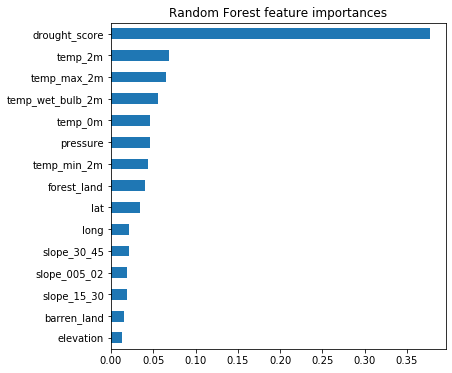

In [18]:
importances_rand_forest = rand_forest.best_estimator_.feature_importances_
importances_rand_forest = pd.Series(importances_rand_forest, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_rand_forest.plot.barh(ax=ax)
ax.set_title('Random Forest feature importances')

In [12]:
import xgboost

params={
  'objective': ['binary:logistic'],
  'max_depth': [3, 6, 9],
  'gamma':[0, 0.1, 0.5],
  'learning_rate': [0.1, 0.2, 0.3],
  'n_estimators': [200],
  'eval_metric': ['logloss']
}
# params={
#   'objective': ['binary:logistic'],
#   'max_depth': [5],
#   'gamma':[0.5],
#   'subsample': [0.5],
#   'colsample_bytree': [0.1],
#   'colsample_bylevel': [1.0],
#   'learning_rate': [0.1, 0.2],
#   'n_estimators': [200],
#   'eval_metric': ['logloss']
# }

xgb = xgboost.XGBClassifier(seed=42, use_label_encoder=False)

xgb = RandomizedSearchCV(xgb, params, scoring="recall")

xgb.fit(X_train, y_train)

print("Best Params:", xgb.best_params_)

Best Params: {'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'eval_metric': 'logloss'}


In [13]:
y_pred_xgb = xgb.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       1.00      0.98      0.99      4254
        True       0.98      1.00      0.99      4146

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



Text(0.5, 1.0, 'XGBoost feature importances')

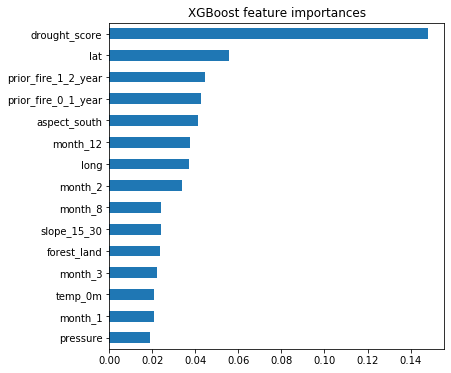

In [7]:
importances_xgb = xgb.best_estimator_.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

In [8]:
import lightgbm as lgbm

gbm = lgbm.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.4],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

# For performance use the best params
# params = {'objective': ['binary'], 'num_leaves': [5000], 'min_data_in_leaf': [800], 'metric': ['binary_logloss'], 'max_depth': [6],
#           'max_bin': [200], 'learning_rate': [0.8], 'feature_fraction': [0.2], 'bagging_freq': [1], 'bagging_fraction': [0.7]}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)


/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.7],
                                        'bagging_freq': [1],
                                        'feature_fraction': [0.2],
                                        'learning_rate': [0.8],
                                        'max_bin': [200], 'max_depth': [6],
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': [800],
                                        'num_leaves': [5000],
                                        'objective': ['binary']},
                   scoring='recall')

In [9]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

# print('--------- LightGBM Report for Original Training Data ---------')
# y_train_pred_gbm = gbm.predict(X_train)
# print(classification_report(y_train, y_train_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 5000, 'min_data_in_leaf': 800, 'metric': 'binary_logloss', 'max_depth': 6, 'max_bin': 200, 'learning_rate': 0.8, 'feature_fraction': 0.2, 'bagging_freq': 1, 'bagging_fraction': 0.7}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.96      0.95      0.96      4254
        True       0.95      0.96      0.96      4146

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



Text(0.5, 1.0, 'LGBM feature importances')

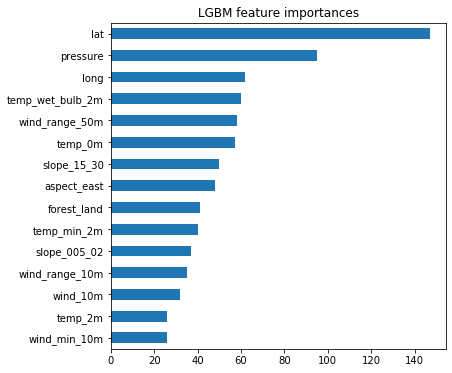

In [10]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')

### Only Larger Fire Sizes (10-5000+ arces)

A=0-0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres

In [30]:
df_no_fire_large = df_fires[df_fires.fire_size_class < 'C']
df_yes_fire_large = df_fires[df_fires.fire_size_class >= 'C']
print(f'Unbalanced classes of NO fire: {len(df_no_fire_large):,} and YES fire: {len(df_yes_fire_large):,}')

df_yes_fire_large_balanced = df_yes_fire_large.sample(n=len(df_no_fire_large), replace=True)

df_fires_large = pd.concat([df_no_fire_large, df_yes_fire_large_balanced], axis=0)
df_no_fire_large = df_fires_large[df_fires_large.fire_size_class < 'C']
df_yes_fire_large = df_fires_large[df_fires_large.fire_size_class >= 'C']
print(f'Balanced classes of NO fires: {len(df_no_fire_large):,} and YES fire: {len(df_yes_fire_large):,}')

# Ignore small fires ('', 'A', 'B') for now
df_fires_large['has_fire'] = df_fires_large.fire_size_class >= 'C'

df_fires_large_numeric = df_fires_large.drop(['date', 'fire_size_class', 'has_fire'], axis=1)

df_fires_large_encoded = pd.get_dummies(df_fires_large_numeric, columns=['month'])

scaler = StandardScaler()
scaler.fit(df_fires_large_encoded)

X_large = scaler.transform(df_fires_large_encoded)
y_large = df_fires_large.has_fire

X_large_train, X_large_test, y_large_train, y_large_test = train_test_split(X_large, y_large, random_state=42)
print(f'X_train: {len(X_large_train)}, X_test: {len(X_large_test)}, y_train: {len(y_large_train)}, y_test: {len(y_large_test)}')

Unbalanced classes of NO fire: 31,813 and YES fire: 1,784
Balanced classes of NO fires: 31,813 and YES fire: 31,813
X_train: 47719, X_test: 15907, y_train: 47719, y_test: 15907


In [27]:
params={
  'C': [0.1],
}

log_reg_large = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg_large = GridSearchCV(estimator=log_reg_large, param_grid=params, scoring='recall', cv=5)

log_reg_large.fit(X_large_train, y_large_train)

print(f'10+ acre fires estimator', log_reg_large.best_estimator_)

y_large_pred_log_reg = log_reg_large.predict(X_large_test)

print('--------- Log Regression Classification (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_log_reg))

10+ acre fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.77      0.66      0.71      7899
        True       0.71      0.81      0.75      8008

    accuracy                           0.73     15907
   macro avg       0.74      0.73      0.73     15907
weighted avg       0.74      0.73      0.73     15907



In [28]:
import xgboost

# params = {
#     'objective': ['binary:logistic'],
#     'max_depth': [3, 6, 9],
#     'gamma': [0, 0.1, 0.4],
#     # 'subsample': [0.5],
#     # 'colsample_bytree': [0.1],
#     # 'colsample_bylevel': [1.0],
#     'learning_rate': [0.1, 0.2],
#     'n_estimators': [200],
#     'eval_metric': ['logloss']
# }
params = {'eval_metric': ['logloss'], 'gamma': [0], 'learning_rate': [0.1],
          'max_depth': [9], 'n_estimators': [200], 'objective': ['binary:logistic']}

xgb_large = xgboost.XGBClassifier(seed=42, use_label_encoder=False)
xgb_large = GridSearchCV(estimator=xgb_large, scoring="recall", param_grid=params)

xgb_large.fit(X_large_train, y_large_train)

print("10+ acre best Params:", xgb_large.best_params_)

y_large_pred_xgb = xgb_large.predict(X_large_test)

print('--------- XGBoost Classification Report (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_xgb))

10+ acre best Params: {'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic'}
--------- XGBoost Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       1.00      0.97      0.98      7899
        True       0.97      1.00      0.98      8008

    accuracy                           0.98     15907
   macro avg       0.98      0.98      0.98     15907
weighted avg       0.98      0.98      0.98     15907



In [34]:
from dtreeviz import trees 

feat_cols = df_fires_large_encoded.columns.to_list()
trees.dtreeviz(xgb_large.best_estimator_, df_fires_large_encoded, df_fires_large.has_fire, feat_cols, 'Yes Fire', class_names=[0, 1], tree_index=1)

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


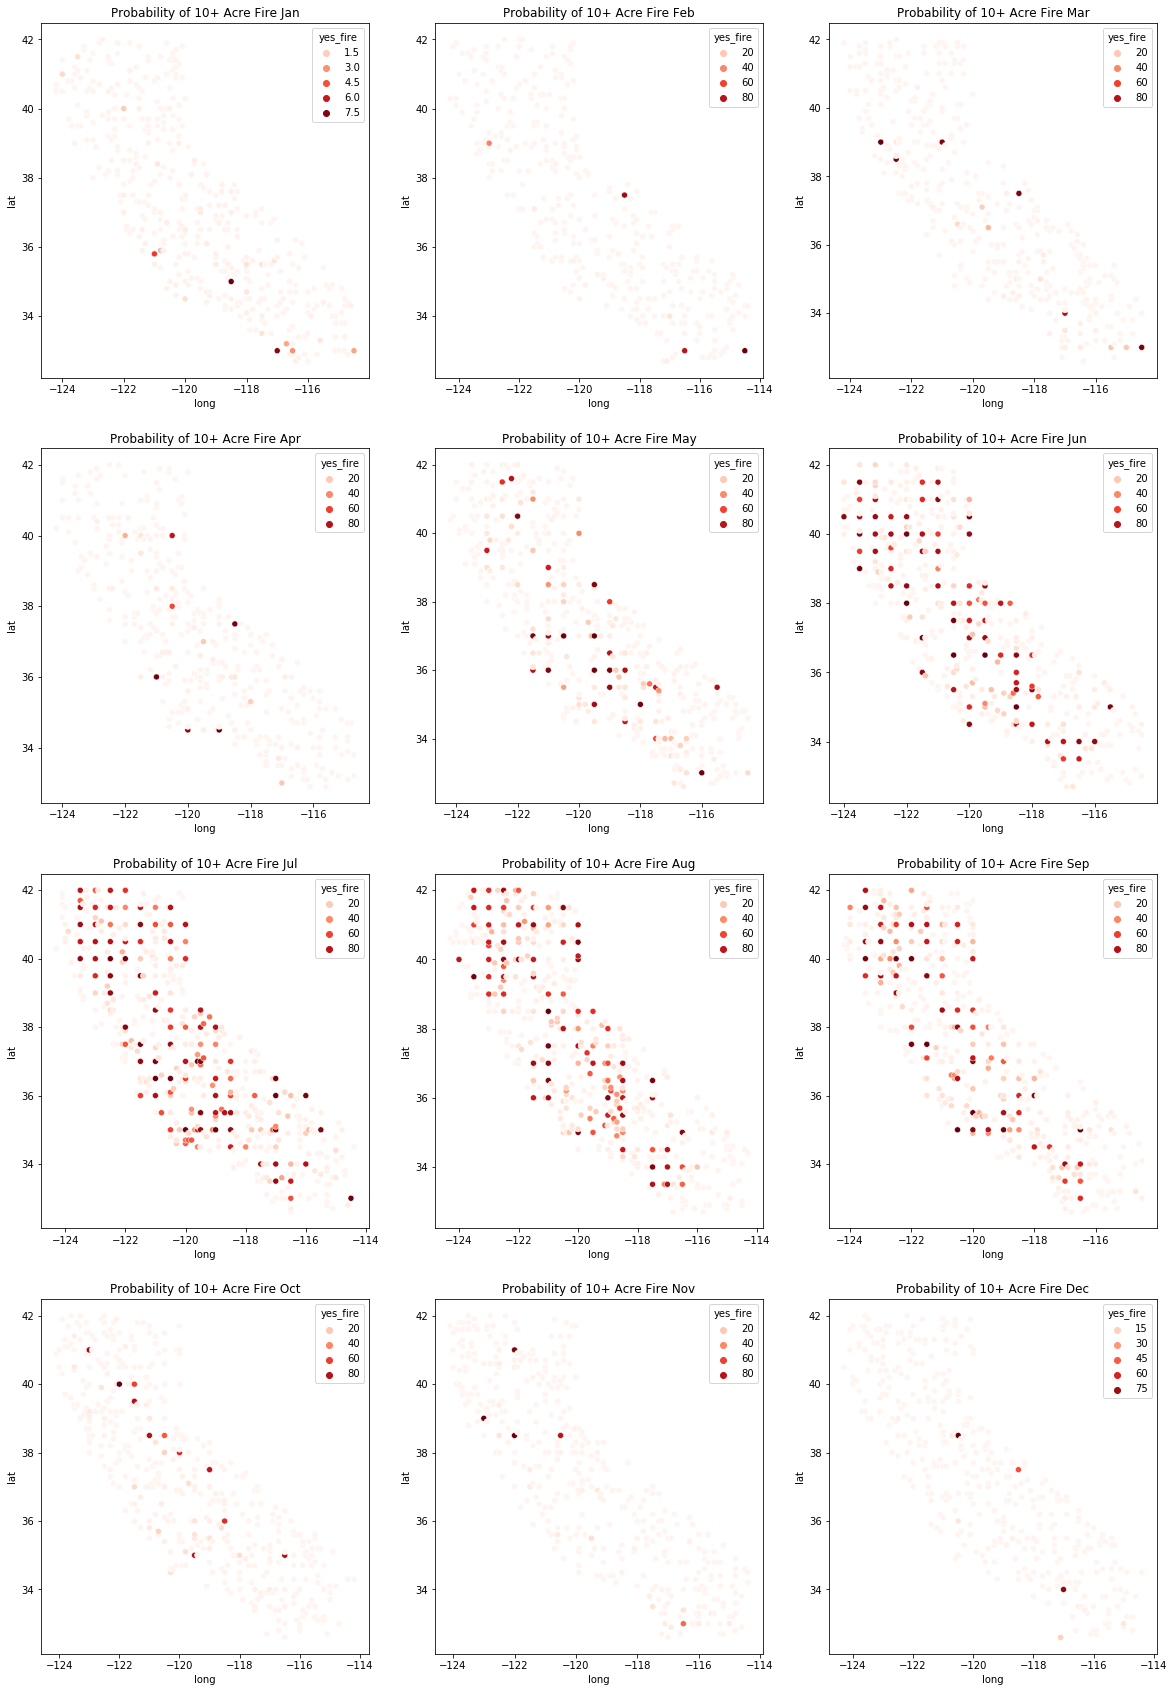

In [31]:
import datetime

X_large_orig_test = train_test_split(df_fires_large, y_large, random_state=42)[1]
X_large_orig_test = X_large_orig_test.reset_index(drop=True)
large_proba_xgb = pd.DataFrame(xgb_large.predict_proba(X_large_test), columns=['no_fire', 'yes_fire'])
large_proba_xgb = pd.concat([X_large_orig_test, large_proba_xgb], axis=1)
large_proba_xgb['yes_fire'] = large_proba_xgb.yes_fire * 100
large_proba_xgb = large_proba_xgb.drop(columns=large_proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
large_proba_month = large_proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index()

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of 10+ Acre Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=large_proba_month[large_proba_month.month == i],
                    palette='Reds', hue='yes_fire')


In [32]:
import lightgbm as lgb

gbm_large = lgb.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.5, 0.8, 1.2],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

gbm_large = RandomizedSearchCV(estimator=gbm_large, param_distributions=params, scoring="recall", cv=3)
gbm_large.fit(X_large_train, y_large_train)

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] feature_fraction is set=0.8000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000000000000003
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] feature_fraction is set=0.8000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000000000000003
[LightGBM] [Warning] bagging_freq is set=5

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.2, 0.5, 0.8,
                                                          1.2],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                                  

In [33]:
print(f'Best params: {gbm_large.best_params_}')

y_large_pred_gbm = gbm.predict(X_large_test)

print('--------- LightGBM Classification Report (10+ acre fires) ---------')
print(classification_report(y_large_test, y_large_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 5000, 'min_data_in_leaf': 400, 'metric': 'binary_logloss', 'max_depth': 7, 'max_bin': 300, 'learning_rate': 0.5, 'feature_fraction': 0.8000000000000003, 'bagging_freq': 5, 'bagging_fraction': 0.6000000000000001}
--------- LightGBM Classification Report (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.58      0.77      0.66      7899
        True       0.67      0.46      0.55      8008

    accuracy                           0.61     15907
   macro avg       0.63      0.61      0.60     15907
weighted avg       0.63      0.61      0.60     15907

